In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('bat_tweets_final.csv')

In [3]:
df.shape

(19443, 37)

In [4]:
df.date.min()

'2018-12-31'

In [5]:
df.date.max()

'2022-06-09'

In [6]:
df['created_at'] = pd.to_datetime(df.created_at)

In [7]:
#create variable to indicate whether tweet came before or after 2020
df['covid'] = np.where(df.created_at < "2019-12-31", "pre", "post")

In [12]:
#initial cleaning
import re
import string
def clean_tweet(tweet):
    if type(tweet) == float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions
    temp = re.sub("@[A-Za-z0-9_]+","", temp) # remove mentions
    temp = re.sub("#[A-Za-z0-9_]+","", temp) # remove hashtags
    temp = re.sub(r'http\S+', '', temp) # remove urls
    temp = re.sub('[%s]' % re.escape(string.punctuation), '', temp) #remove puncuation
    temp = re.sub("[^a-z0-9]"," ", temp) #filter non-alphanumeric characters
    return temp
results = [clean_tweet(tw) for tw in df.tweet]
results

['vortex wind power is wildlifefriendly and safe for birds bats bees sugar amp squirrel gliders but bladed wind turbines kill millions of native wildlife species annually  110   330 birds amp 200   670 bats per wind turbine are mutilated and die lt ',
 '       but i think you have ignored my point about the damage intensive agriculture does in the first place the wildlife that could be there isn t autumn hacking of hedges so no food or cover spraying removing insects so no bats trees gone lincs farms are not full of biodiversity',
 ' not sure why  characterises protected species such as bats as pests  ditto bees etc  reinforcing negative stereotypes of our valuable wildlife someone needs to rewrite this page  ',
 '  nah the native stuff is all pretty friendly the only native mammal is a tiny ickle bat the only venomous spider is so rare its an endangered species australian wildlife now that is terrifying',
 'read this about bats         ',
 'any ideas what this might be  looks like som

### Lemmatize words

In [18]:
#lemmatize words
import spacy
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])
def lemmatize_tweet(tweet):
    doc = load_model(tweet)
    temp = " ".join([token.lemma_ for token in doc])
    return temp
lem_results = [lemmatize_tweet(tweet) for tweet in results]
lem_results

['vortex wind power be wildlifefriendly and safe for bird bat bee sugar amp squirrel glider but blade wind turbine kill million of native wildlife specie annually   110    330 bird amp 200    670 bat per wind turbine be mutilate and die lt',
 '        but I think you have ignore my point about the damage intensive agriculture do in the first place the wildlife that could be there isn t autumn hack of hedge so no food or cover spray remove insect so no bat tree go linc farm be not full of biodiversity',
 '  not sure why   characterise protect specie such as bat as pest   ditto bee etc   reinforce negative stereotype of our valuable wildlife someone need to rewrite this page  ',
 '   nah the native stuff be all pretty friendly the only native mammal be a tiny ickle bat the only venomous spider be so rare its an endangered species australian wildlife now that be terrify',
 'read this about bat         ',
 'any idea what this might be   look like some kind of camera   maybe for wildlife or

### Filter out non-English words

In [19]:
#get rid of non-english words
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())
clean_tweet = []
for tweet in lem_results:
    clean_tweet.append(" ".join(w for w in nltk.wordpunct_tokenize(tweet) if w in words and w.isalpha()))
df['clean_tweet'] = clean_tweet

[nltk_data] Downloading package words to /Users/ngoodby/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Scattertext

In [ ]:
#create scattertext html of pre and post covid terms
import scattertext as st

df['metadata'] = df.created_at.map(str) + " | " + df.clean_tweet

nlp = spacy.load('en_core_web_sm')
nlp.Defaults.stop_words |= {"bat","wildlife"}
corpus = st.CorpusFromPandas(df, category_col='covid', text_col='clean_tweet', nlp=nlp).build()

html = st.produce_scattertext_explorer(corpus,
                                       category='pre',
                                       category_name='Pre-Covid',
                                       not_category_name='Post-Covid',
                                       width_in_pixels=1000,
                                       metadata = corpus.get_df()['metadata'])
open("pre_post_covid.html", 'wb').write(html.encode('utf-8'))

### Some additional EDA adjustments

In [20]:
#get rid of some tweets that have little meaning, get rid of tweets about baseball
df = df[df.clean_tweet != 'read this about bat'] 
df = df[df.clean_tweet != 'what be bat']
df = df[df.clean_tweet != 'bat']
df = df[df.clean_tweet != 'the bat']
df = df[df.clean_tweet.str.contains("baseball bat")==False]
df.reset_index(drop = True, inplace=True)

### Create wordclouds for before and after 2020

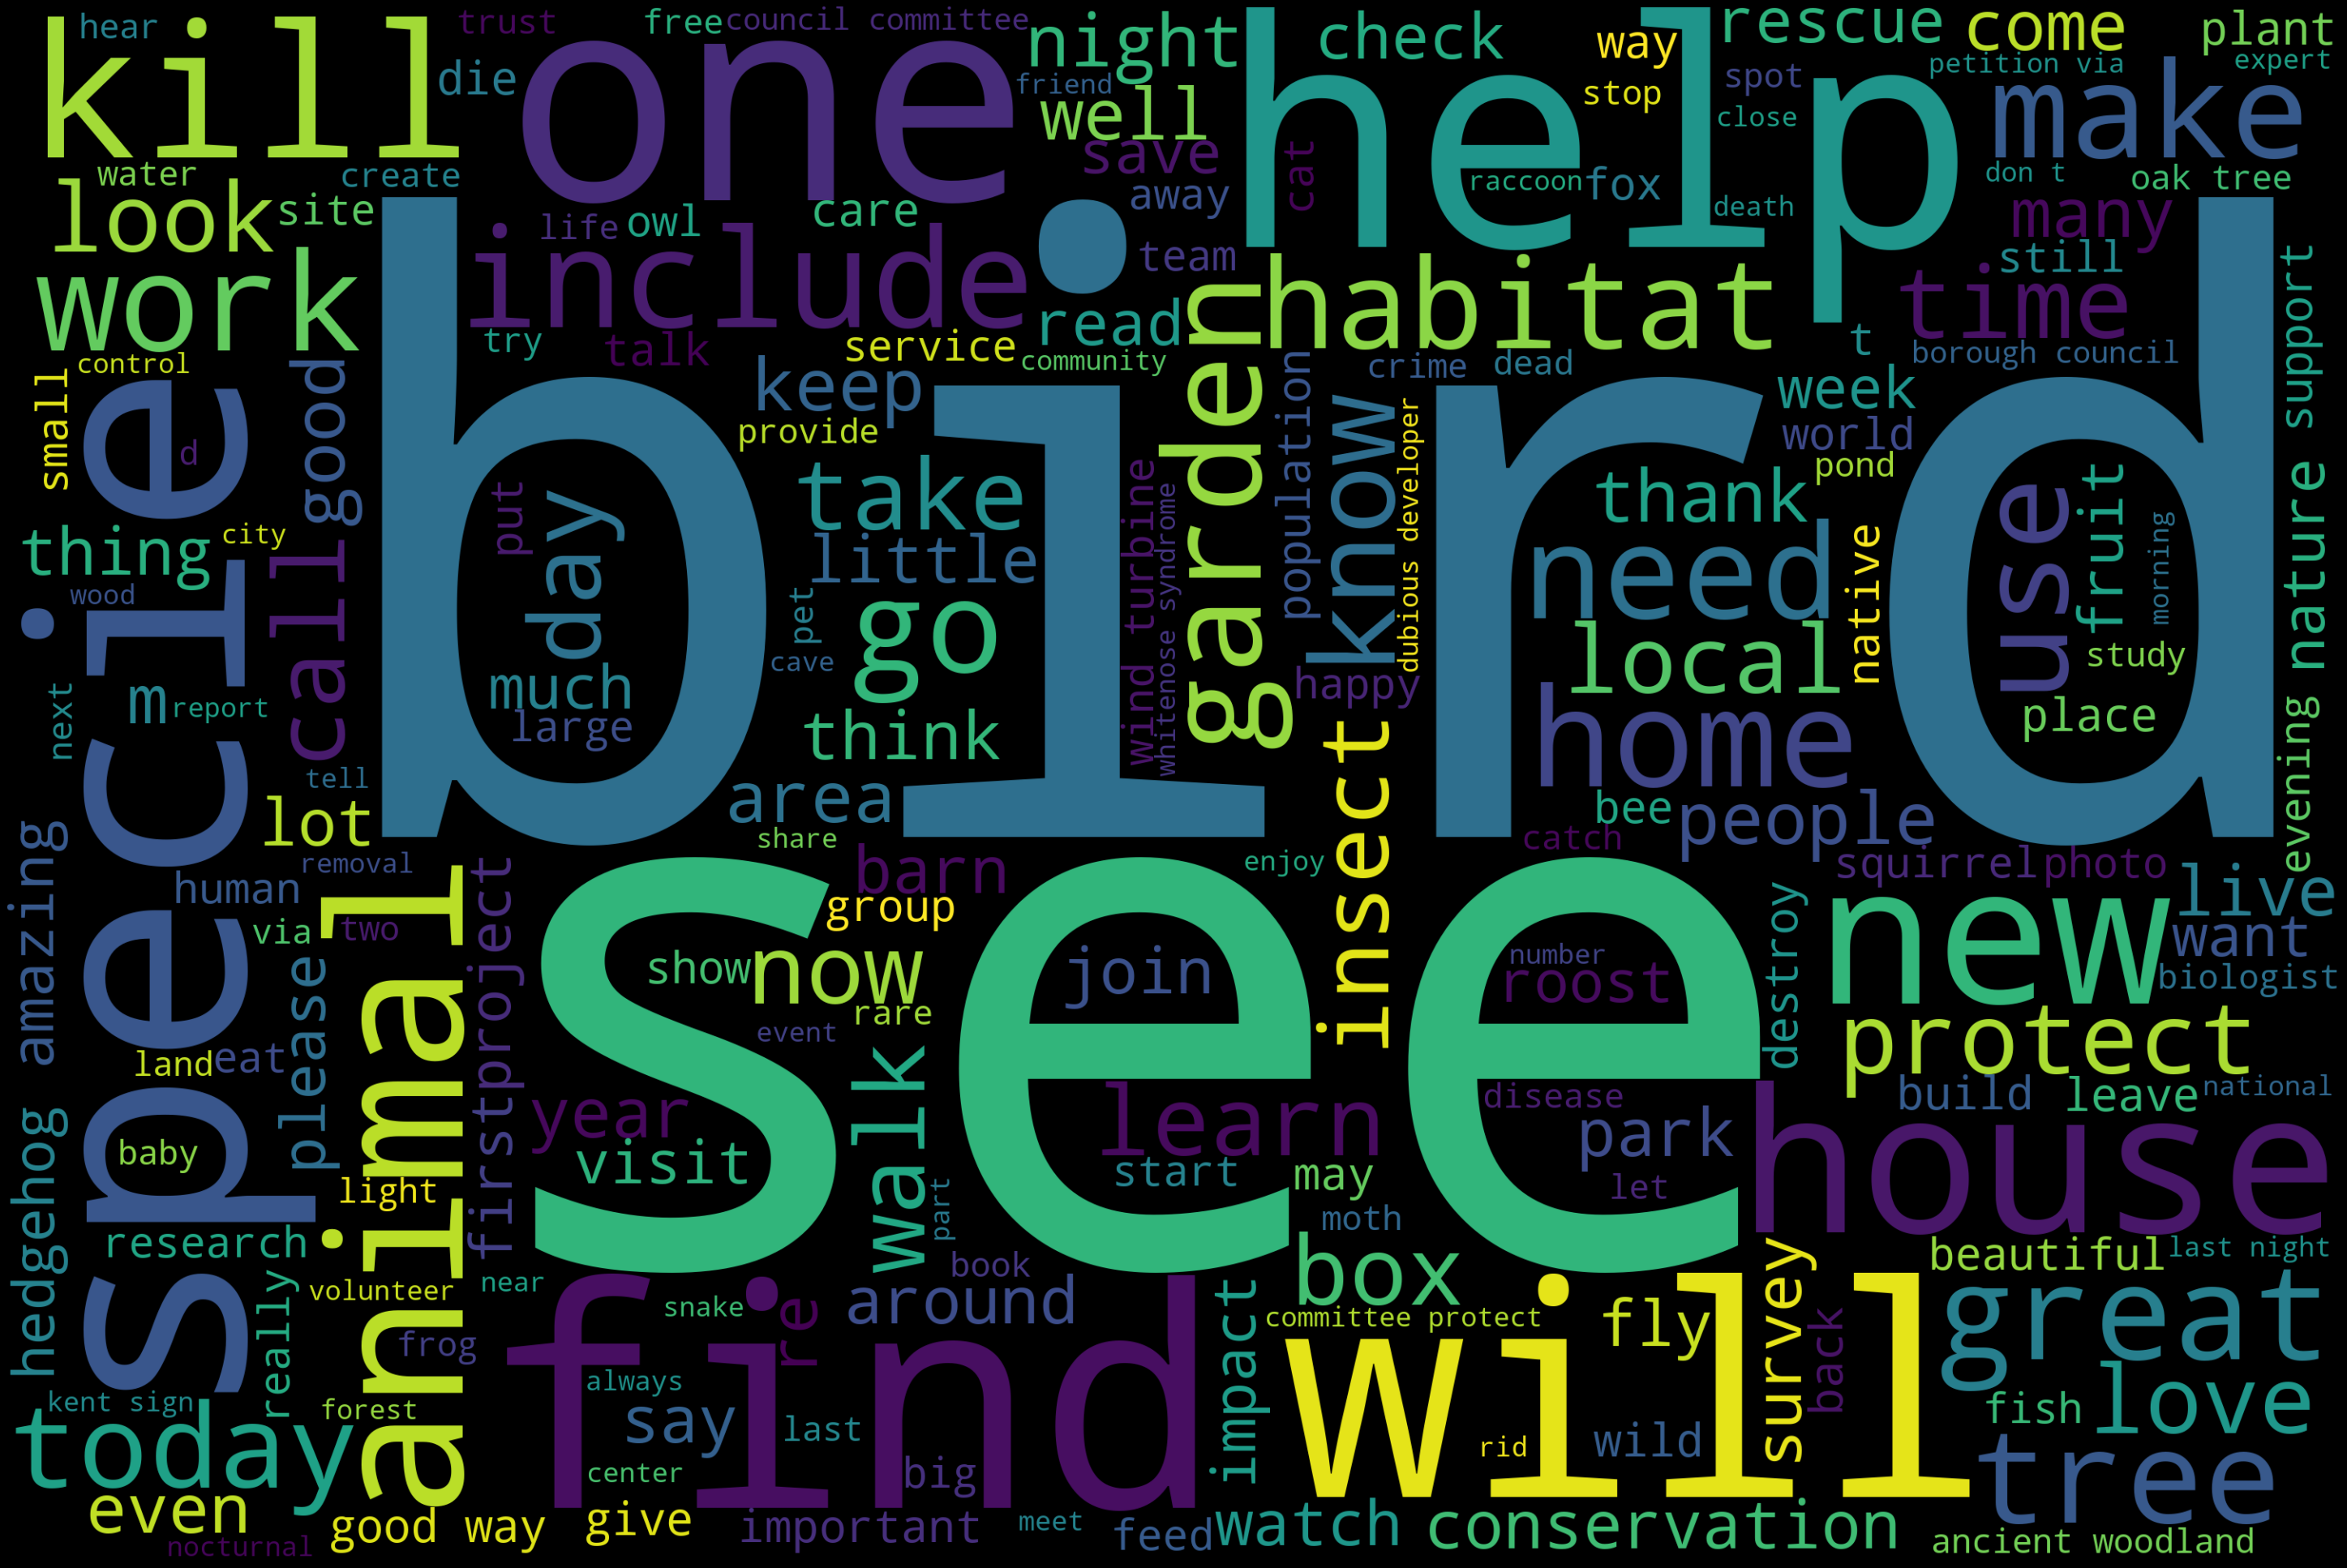

<Figure size 432x288 with 0 Axes>

In [21]:
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt

stopwords = ['bat','wildlife', 's'] + list(STOPWORDS)
pre_tweets = " ".join(tweet for tweet in df.clean_tweet[df.covid=='pre'])
pre_wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      background_color = 'black',
                      stopwords = stopwords).generate(pre_tweets)
fig = plt.figure(figsize = (40, 30),
                 facecolor = 'k',
                 edgecolor = 'k')
plt.imshow(pre_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.tight_layout()

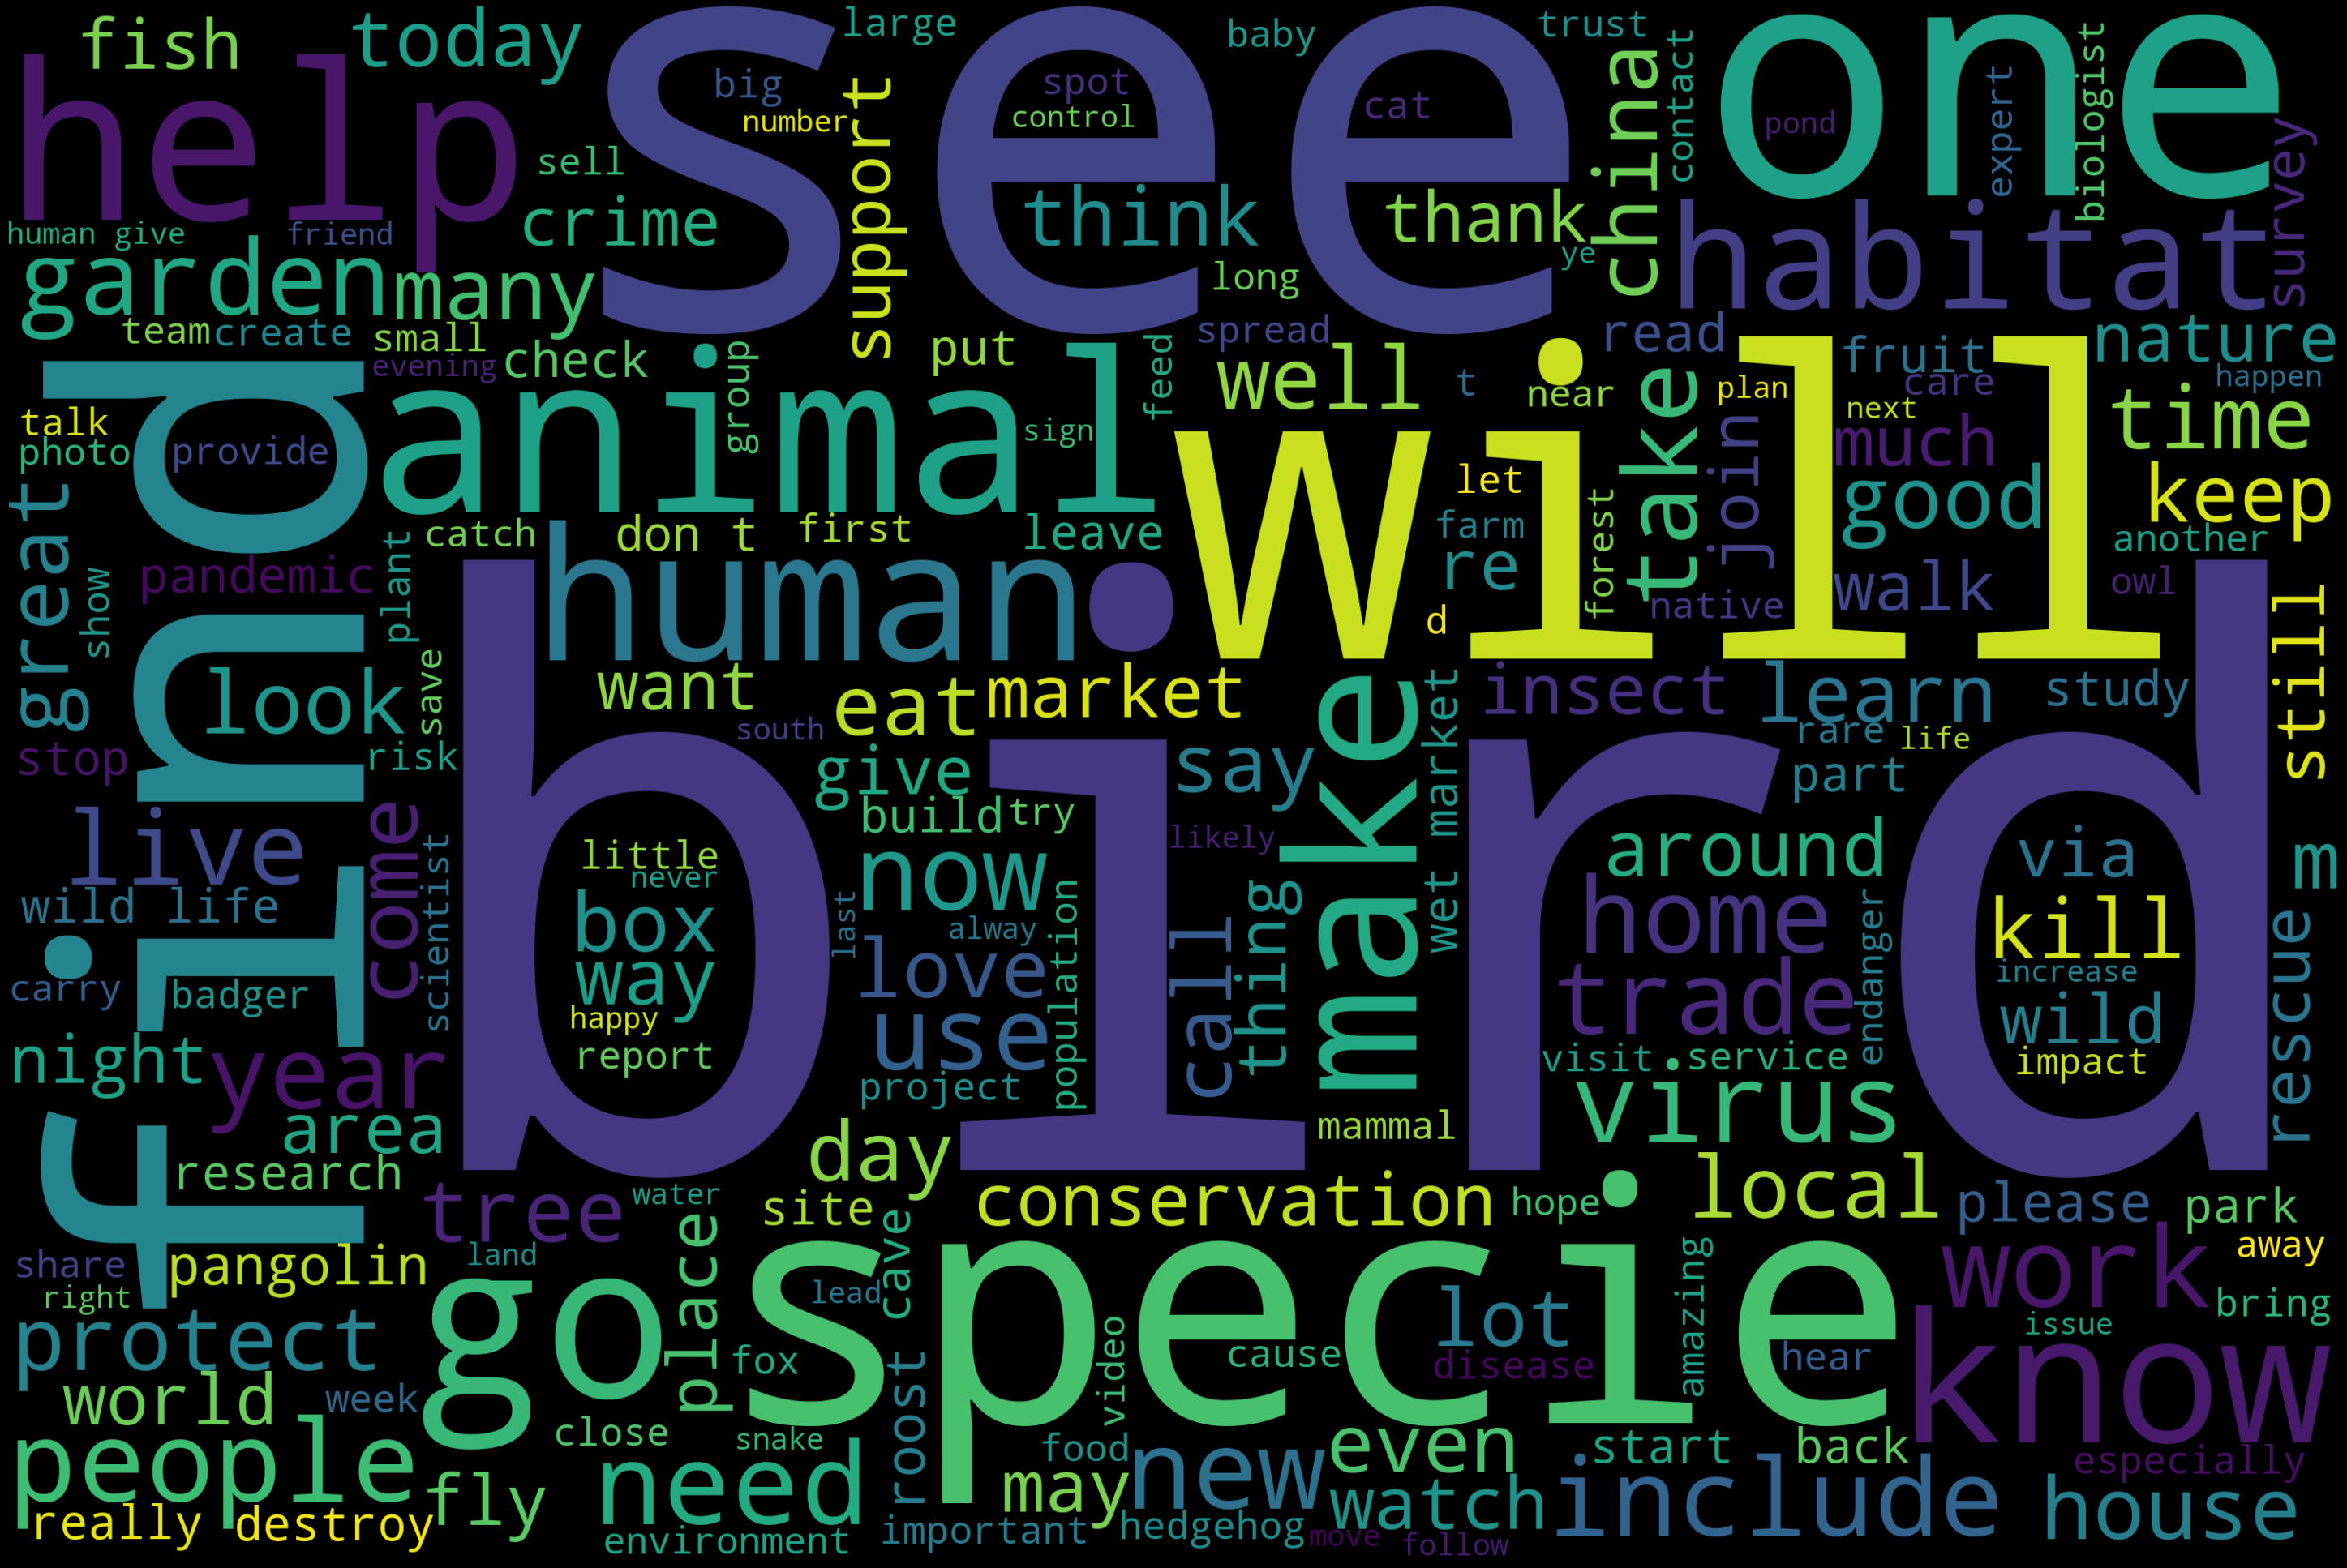

<Figure size 432x288 with 0 Axes>

In [22]:
post_tweets = " ".join(tweet for tweet in df.clean_tweet[df.covid=='post'])
post_wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      background_color = 'black',
                      stopwords = stopwords).generate(post_tweets)
fig = plt.figure(figsize = (40, 30),
                 facecolor = 'k',
                 edgecolor = 'k')
plt.imshow(post_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.tight_layout()

### Create document-term matrix using CountVectorizer

Note that I tried both TfidfVectorizer and CountVectorizer and found topics to be more coherent using CountVectorizer. This feels like an acceptable choice given that tweets are relatively short.

In [23]:
#create document term matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text

#specify stop words to remove
my_stop_words = text.ENGLISH_STOP_WORDS.union(["aa","bat","wildlife","just","like",
                                               "great","make","work","new","know","s"]) 
cv = CountVectorizer(strip_accents = "ascii",
                          stop_words = my_stop_words)
X = cv.fit_transform(df.clean_tweet).toarray()
df_cv = pd.DataFrame(X, index = df.clean_tweet,columns = cv.get_feature_names())

In [24]:
df_cv.shape

(19188, 10446)

In [25]:
#look at most common words to get a gut check on if things are making sense
df_cv.sum().sort_values(ascending = False).head(20)

bird       2320
animal     1709
specie     1625
help       1443
habitat    1172
human      1032
tree       1015
include     948
protect     947
year        941
good        937
people      919
home        903
need        901
wild        900
kill        882
virus       844
live        820
garden      816
house       815
dtype: int64

### Perform topic modeling using non-negative matrix factorization

In [26]:
#topic modeling
from sklearn.decomposition import NMF
nmf = NMF(n_components=3, init = "nndsvda", max_iter=500)
doc_topic = nmf.fit_transform(df_cv)

In [27]:
nmf.components_.shape

(3, 10446)

In [28]:
def get_top_terms(topic, n_terms, nmf=nmf, terms=df_cv.columns):
    # get the topic components (i.e., term weights)
    components = nmf.components_[topic, :]

    # get term indices, sorted (descending) by topic weights
    top_term_indices = components.argsort()[-n_terms:]
    
    # use the `terms` array to get the actual top terms
    top_terms = np.array(terms)[top_term_indices]
    
    return top_terms.tolist()

In [29]:
#show the top 10 terms in each topic
topic_terms_df = pd.DataFrame()
for i in range(0,3):
    topic_terms = pd.Series(get_top_terms(i,10), name = i)
    topic_terms_df = pd.concat([topic_terms_df, topic_terms], axis = 1)
    print(f'Topic {i}:')
    print(get_top_terms(i, 10))
    print("\n")
topic_terms_df.rename(mapper = {0:'Wind',1:'Disease',2:'Habitat'}, axis = 1, inplace = True)

Topic 0:
['include', 'bee', 'turbine', 'insect', 'kill', 'garden', 'habitat', 'box', 'wind', 'bird']


Topic 1:
['wet', 'eat', 'trade', 'live', 'china', 'wild', 'market', 'virus', 'human', 'animal']


Topic 2:
['local', 'include', 'people', 'need', 'home', 'habitat', 'tree', 'protect', 'help', 'specie']




In [30]:
topic_terms_df

Wind Disease  Habitat
0  include     wet    local
1      bee     eat  include
2  turbine   trade   people
3   insect    live     need
4     kill   china     home
5   garden    wild  habitat
6  habitat  market     tree
7      box   virus  protect
8     wind   human     help
9     bird  animal   specie

In [31]:
#name topics and create a dataframe of topic focus for each tweet
topic_names = ["wind","disease","habitat"]
doc_topic_df = pd.DataFrame(doc_topic.round(5), index = df.index, columns = topic_names)

In [32]:
#label each document with its primary topic
doc_topic_df['primary_topic'] = doc_topic_df.idxmax(axis=1)

In [33]:
#add the primary topic of each document to the original dataframe
df = pd.merge(df, doc_topic_df.primary_topic, 
                  left_index=True, right_index=True)
df.head()

Unnamed: 0                   id      conversation_id  \
0           0  1211419544327049216  1211419544327049216   
1           1  1211385033740750848  1210970526707003392   
2           2  1211337026114596865  1210511139483930624   
3           3  1211289617468657664  1211083006951198720   
4           5  1211233587011260416  1211233587011260416   

                 created_at        date      time  timezone  \
0 2019-12-29 14:51:41-08:00  2019-12-29  14:51:41      -700   
1 2019-12-29 12:34:33-08:00  2019-12-29  12:34:33      -700   
2 2019-12-29 09:23:47-08:00  2019-12-29  09:23:47      -700   
3 2019-12-29 06:15:24-08:00  2019-12-29  06:15:24      -700   
4 2019-12-29 02:32:45-08:00  2019-12-29  02:32:45      -700   

              user_id       username                name  ...  \
0          2572647895    c_bennett95   Christine Bennett  ...   
1  748928752382570496  velohistorian      Richard Parker  ...   
2            23773094       anroache       CamberwickKid  ...   
3            90972488         ibosnz       Ian Bosley 🔑🟤  ...   
4           296805562  canungratimes  The Canungra Times  ...   

                                            reply_to retweet_date translate  \
0                                                 []          NaN       NaN   
1  [{'screen_name': 'wheat_daddy', 'name': 'Andre...          NaN       NaN   
2  [{'screen_name': 'Livingstone_RJ', 'name': 'Ri...          NaN       NaN   
3  [{'screen_name': 'sioncorn', 'name': 'feckless...          NaN       NaN   
4                                                 []          NaN       NaN   

  trans_src trans_dest covid  \
0       NaN        NaN   pre   
1       NaN        NaN   pre   
2       NaN        NaN   pre   
3       NaN        NaN   pre   
4       NaN        NaN   pre   

                                            metadata  \
0  2019-12-29 14:51:41-08:00 | vortex wind power ...   
1  2019-12-29 12:34:33-08:00 |        but i think...   
2  2019-12-29 09:23:47-08:00 |  not sure why  cha...   
3  2019-12-29 06:15:24-08:00 |   nah the native s...   
4  2019-12-29 02:32:45-08:00 | any ideas what thi...   

                                         clean_tweet  \
0  vortex wind power be and safe for bird bat bee...   
1  but I think you have ignore my point about the...   
2  not sure why protect specie such as bat as pes...   
3  the native stuff be all pretty friendly the on...   
4  any idea what this might be look like some kin...   

                                   scattertext_tweet primary_topic  
0  vortex wind power is wildlifefriendly and safe...          wind  
1         but i think you have ignored my point a...       habitat  
2   not sure why  characterises protected species...       habitat  
3    nah the native stuff is all pretty friendly ...       habitat  
4  any ideas what this might be  looks like some ...       habitat  

[5 rows x 42 columns]

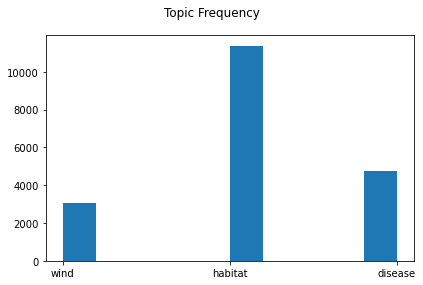

In [34]:
#look at overall frequency of different topics
import seaborn as sns

fig, ax = plt.subplots()
ax.hist(df.primary_topic)
fig.suptitle('Topic Frequency')
fig.tight_layout();

### Sentiment analysis using Vader

In [35]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
df['score'] = df.clean_tweet.map(analyzer.polarity_scores).map(lambda x: x.get('compound'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ngoodby/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [36]:
#print the most positive tweet
df.clean_tweet.iloc[df.score.idxmax()]

'congratulation to the recipient of the habitat trust grant strategic partnership grant the foundation habitat grant seed trust specie grant bat conservation trust conservation hero grant m'

In [37]:
#print the most negative tweet
df.clean_tweet.iloc[df.score.idxmin()]

'kill the shark kill the koala kill the wildlife kill bird specie kill the forest kill the small town with coal mine or kill all old tree kill the bogong kill the bat kill the planet nice work premier will not be anything leave after your mob finish'

In [38]:
#print the overall sentiment score
df.score.mean()

0.19908352616218308

In [39]:
#assign positive or negative overall score to each tweet and then calculate percentage of positive tweets
df['sent'] = df.score.apply(lambda x: 'pos' if x>=0 else 'neg')
print("Percentage of negative tweets about bats pre-Covid:")
print(f"{(((df[df.covid=='pre'].sent[df.sent=='neg'].count())/len(df[df.covid=='pre']))*100).round(2)}%\n")
print(f"Percentage of negative tweets about bats post-Covid:")
print(f"{(((df[df.covid=='post'].sent[df.sent=='neg'].count())/len(df[df.covid=='post']))*100).round(2)}%\n")

Percentage of negative tweets about bats pre-Covid:
21.35%

Percentage of negative tweets about bats post-Covid:
26.05%



### Vizualize change in topics over time

In [40]:
df['month_year'] = df['created_at'].dt.to_period('M')

/Users/ngoodby/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [41]:
topic_count_df = df.groupby(['month_year','primary_topic'])['primary_topic'].count().to_frame(name='topic_count').reset_index()

In [42]:
topic_count_df.head()

month_year primary_topic  topic_count
0    2018-12       habitat            1
1    2019-01       disease           72
2    2019-01       habitat          309
3    2019-01          wind           69
4    2019-02       disease           53

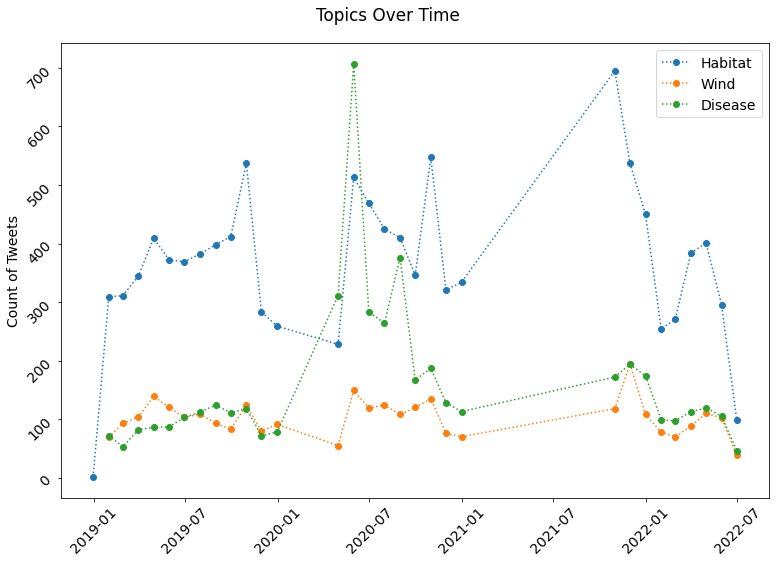

In [49]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
plt.plot_date(topic_count_df['month_year'][topic_count_df.primary_topic == "habitat"], 
              topic_count_df['topic_count'][topic_count_df.primary_topic == "habitat"], 
             xdate=True,
             ydate=False,
             linestyle = 'dotted')
plt.plot_date(topic_count_df['month_year'][topic_count_df.primary_topic == "wind"], 
              topic_count_df['topic_count'][topic_count_df.primary_topic == "wind"], 
             xdate=True,
             ydate=False,
             linestyle = 'dotted')
plt.plot_date(topic_count_df['month_year'][topic_count_df.primary_topic == "disease"], 
              topic_count_df['topic_count'][topic_count_df.primary_topic == "disease"], 
             xdate=True,
             ydate=False,
             linestyle = 'dotted')
ax.legend(labels=['Habitat','Wind','Disease'])
ax.set_ylabel('Count of Tweets')
fig.suptitle('Topics Over Time')
ax.tick_params(labelrotation=45)
plt.tight_layout()
fig.savefig('topics_over_time.jpg', dpi=100)
plt.show()